### Attempt 2

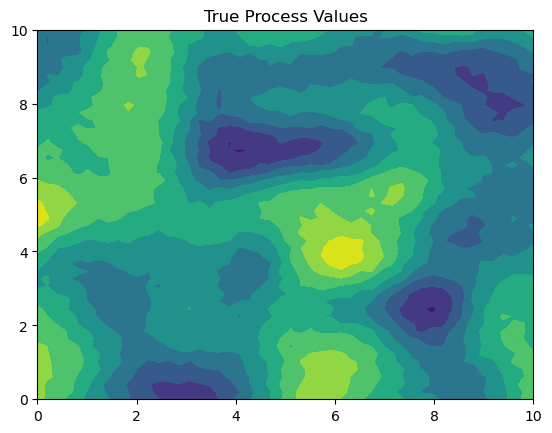

In [12]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from custom_dk_imports import DeepKrigingMLP
from custom_dk_imports import Trainer

np.random.seed(23)
torch.manual_seed(23)

N = 50
x = np.linspace(0, 10, N)
y = np.linspace(0, 10, N)
X, Y = np.meshgrid(x, y)
grid_points = np.vstack([X.ravel(), Y.ravel()]).T  # 2D coordinates

def exponential_kernel(s1, s2, length_scale):
    sqdist = np.sum(s1**2, axis=1).reshape(-1, 1) + np.sum(s2**2, axis=1) - 2 * np.dot(s1, s2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

length_scale = 1.0
cov_matrix = exponential_kernel(grid_points, grid_points, length_scale)
noise_var = 0.01  # Nugget variance
nugget = np.eye(grid_points.shape[0]) * noise_var
cov_matrix += nugget  # Covariance matrix with noise

mean = np.zeros(grid_points.shape[0])
process_values = np.random.multivariate_normal(mean, cov_matrix)

# Visualize the process values
process_values_grid = process_values.reshape(N, N)
plt.contourf(X, Y, process_values_grid)
plt.title("True Process Values")
plt.show()


In [13]:
def uniform_sampling(points, n_samples=50):
    sampled_indices = np.random.choice(len(points), size=n_samples, replace=False)
    return points[sampled_indices], sampled_indices

sampled_points, sampled_indices = uniform_sampling(grid_points)
sampled_values = process_values[sampled_indices]

# from sklearn.model_selection import train_test_split
from custom_dk_imports import DeepKrigingEmbedding2D, spatial_train_val_test_split
s_train, s_val, s_test, y_train, y_val, y_test = spatial_train_val_test_split(
    s=sampled_points, y=sampled_values, train_size=0.7, val_size=0.15, test_size=0.15, shuffle=True, block_sampling=False
)

# input_dim = 0  # Only want model to take in basis functions
num_hidden_layers = 1
hidden_dims = 100
K = 3  # Number of basis functions


# Instantiate the embedding layer
embedding_layer = DeepKrigingEmbedding2D(K=1)
input_dim = sum(embedding_layer.num_basis)  # This should match 1830

# Convert numpy arrays to torch tensors
s_train_tensor = torch.tensor(s_train, dtype=torch.float32)
s_val_tensor = torch.tensor(s_val, dtype=torch.float32)
s_test_tensor = torch.tensor(s_test, dtype=torch.float32)

# Compute the basis functions for each split using the tensor inputs
phi_train = embedding_layer(s_train_tensor)
phi_val = embedding_layer(s_val_tensor)
phi_test = embedding_layer(s_test_tensor)

# Convert y_train, y_val, and y_test to torch tensors
y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
y_val = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

deepkriging_model = DeepKrigingMLP(input_dim, num_hidden_layers, hidden_dims, K=K, activation='identity')

train_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_train, y_train),
    batch_size=32, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_val, y_val),
    batch_size=32, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=torch.utils.data.TensorDataset(phi_test, y_test),
    batch_size=32, shuffle=False
)

data_generators = {'train': train_loader, 'val': val_loader, 'test': test_loader}

trainer = Trainer(
    model=deepkriging_model,
    data_generators={'train': train_loader, 'val': val_loader, 'test': test_loader},
    optim='adam',
    optim_params={'lr': 0.001},
    loss_fn=nn.MSELoss(),
    window_size=10,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    epochs=100,
    patience=10
)

trainer.train()

deepkriging_model.eval()

with torch.no_grad():
    y_pred_deepkriging = deepkriging_model(phi_test).cpu().numpy()
    

Training started:

Epoch 1/100
Learning rate: 0.001000
0s for 2 steps - 3ms/step - loss 0.7398
Validation:
0s - loss 1.0266



Epoch 2/100
Learning rate: 0.001000
0s for 2 steps - 58ms/step - loss 0.7243
Validation:
0s - loss 1.0083

Epoch 3/100
Learning rate: 0.001000
0s for 2 steps - 4ms/step - loss 0.7135
Validation:
0s - loss 0.9956

Epoch 4/100
Learning rate: 0.001000
0s for 2 steps - 2ms/step - loss 0.7032
Validation:
0s - loss 0.9869

Epoch 5/100
Learning rate: 0.001000
0s for 2 steps - 2ms/step - loss 0.6965
Validation:
0s - loss 0.9764

Epoch 6/100
Learning rate: 0.001000
0s for 2 steps - 3ms/step - loss 0.6899
Validation:
0s - loss 0.9653

Epoch 7/100
Learning rate: 0.001000
0s for 2 steps - 2ms/step - loss 0.6822
Validation:
0s - loss 0.9547

Epoch 8/100
Learning rate: 0.001000
0s for 2 steps - 3ms/step - loss 0.6745
Validation:
0s - loss 0.9438

Epoch 9/100
Learning rate: 0.001000
0s for 2 steps - 3ms/step - loss 0.6679
Validation:
0s - loss 0.9328

Epoch 10/100
Learning rate: 0.001000
0s for 2 steps - 2ms/step - loss 0.6604
Validation:
0s - loss 0.9222

Epoch 11/100
Learning rate: 0.001000
0s for 

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF(length_scale=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=noise_var)

gp.fit(s_train, y_train)   
y_pred_gp, y_std_gp = gp.predict(s_test, return_std=True)

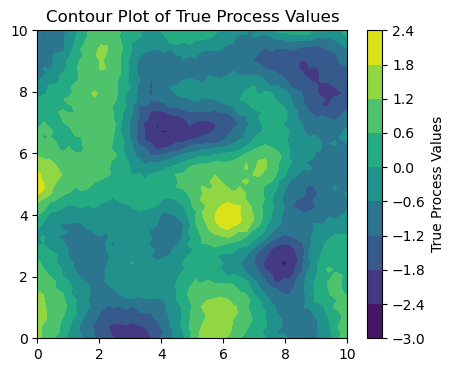

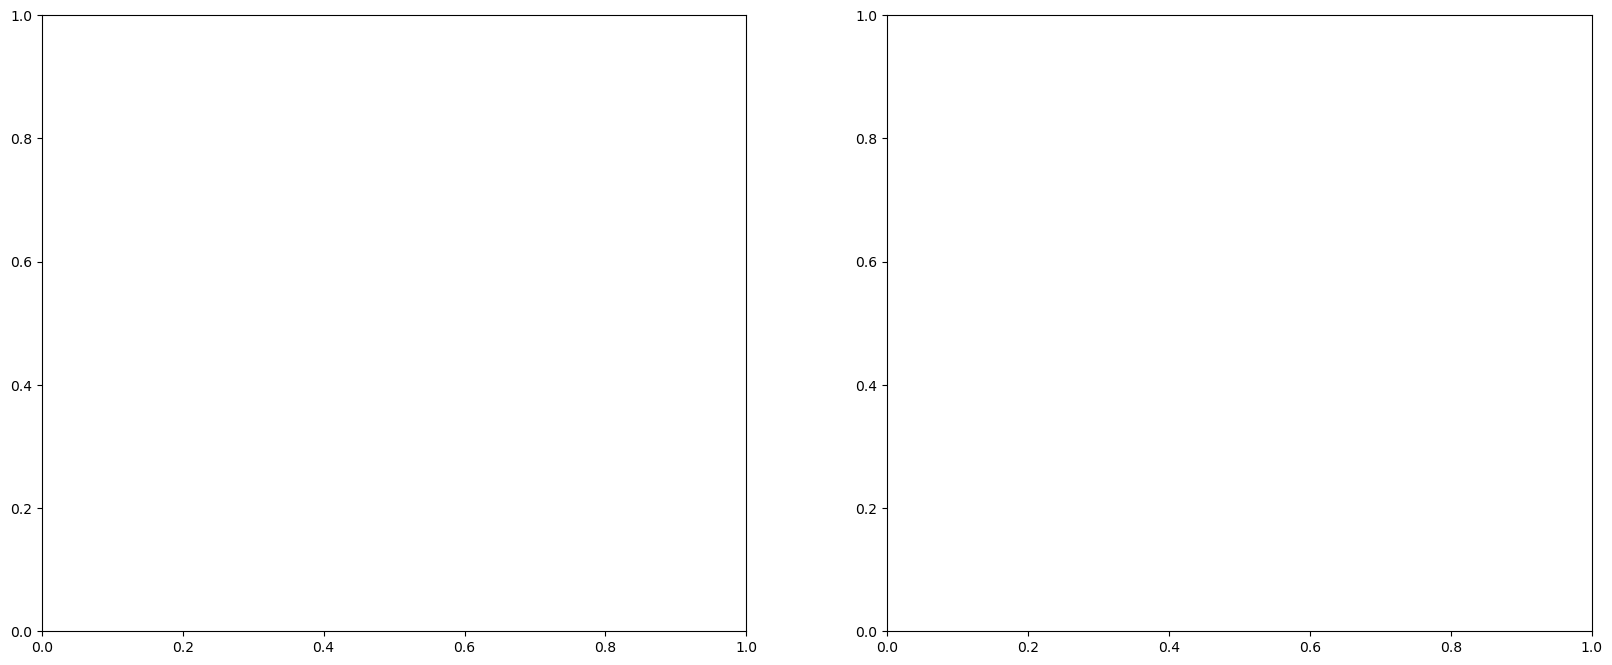

In [15]:
from scipy.interpolate import griddata

# Reshape the true process values to the grid shape
process_values_grid = process_values.reshape(N, N)

# Predict on the test set
y_pred_gp, y_std_gp = gp.predict(s_test, return_std=True)

# Interpolate the predictions to the original grid for contour plotting
y_pred_dk_grid = griddata(s_test, y_pred_deepkriging.squeeze(), (X, Y), method='cubic')
y_pred_gp_grid = griddata(s_test, y_pred_gp.squeeze(), (X, Y), method='cubic')

# Plot true process values on its own first:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

contour1 = ax.contourf(X, Y, process_values_grid, cmap='viridis')
fig.colorbar(contour1, ax=ax, label='True Process Values')
ax.set_title("Contour Plot of True Process Values")
plt.show()

# Assuming y_pred_deepkriging and y_pred_gp are your predictions
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# # Plot DeepKriging predictions directly on the test points
# contour2 = ax[0].contourf(X, Y, y_pred_deepkriging, cmap='viridis')
# fig.colorbar(contour2, ax=ax[0], label='DeepKriging Predictions')
# ax[0].set_title("Contour Plot of DeepKriging Predictions")

# # Plot GP predictions directly on the test points
# contour3 = ax[1].contourf(s_test[:, 0], s_test[:, 1], y_pred_gp, cmap='viridis')
# fig.colorbar(contour3, ax=ax[1], label='GP Predictions')
# ax[1].set_title("Contour Plot of GP Predictions")

plt.show()

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Calculate RMSE and MAPE for DeepKriging (Model 2)
rmse_deepkriging = rmse(y_test.numpy(), y_pred_deepkriging)
mape_deepkriging = mape(y_test.numpy(), y_pred_deepkriging)
print(f"RMSE (DeepKriging): {rmse_deepkriging}")
print(f"MAPE (DeepKriging): {mape_deepkriging}")

# Calculate RMSE and MAPE for Basic GP
rmse_gp = rmse(y_test.numpy(), y_pred_gp)
mape_gp = mape(y_test.numpy(), y_pred_gp)
print(f"RMSE (GP): {rmse_gp}")
print(f"MAPE (GP): {mape_gp}")

RMSE (DeepKriging): 0.6314020156860352
MAPE (DeepKriging): 68.66006469726562
RMSE (GP): 0.7704499707635047
MAPE (GP): 91.1106616568965
